In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Paths (works whether you run from repo root or from notebooks/)
ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_RAW = ROOT / "data_raw"

store_info = pd.read_csv(DATA_RAW / "store_info.csv")
perf = pd.read_csv(DATA_RAW / "store_performance_2018to2022.csv")

# Clean column names (important)
store_info.columns = store_info.columns.str.strip()
perf.columns = perf.columns.str.strip()

# Fix types
perf["invoice_date"] = pd.to_datetime(perf["invoice_date"], errors="coerce")

print("Loaded store_info rows:", len(store_info), "stores:", store_info["store_id"].nunique())
print("Loaded perf rows:", len(perf), "stores:", perf["store_id"].nunique())
print("Perf date range:", perf["invoice_date"].min(), "to", perf["invoice_date"].max())

Loaded store_info rows: 439 stores: 439
Loaded perf rows: 773266 stores: 439
Perf date range: 2018-01-02 00:00:00 to 2022-12-31 00:00:00


In [2]:
# Missing values (%)
print("\nMissing % in perf (top 10):")
print((perf.isna().mean().sort_values(ascending=False).head(10) * 100).round(2))

print("\nMissing % in store_info (top 10):")
print((store_info.isna().mean().sort_values(ascending=False).head(10) * 100).round(2))

# Duplicate check on key
dupes = perf.duplicated(subset=["store_id", "invoice_date"]).sum()
print("\nDuplicate rows on (store_id, invoice_date):", dupes)

# Negative checks
for col in ["invoice_count", "oc_count", "fleet_oc_count"]:
    neg = (perf[col].dropna() < 0).sum()
    print(f"Negative values in {col}: {neg}")

# Store metadata missing after join (quick preview)
df = perf.merge(store_info, on="store_id", how="left")
print("\nRows missing store_latitude after join:", df["store_latitude"].isna().sum())


Missing % in perf (top 10):
invoice_date      0.0
store_id          0.0
invoice_count     0.0
oc_count          0.0
fleet_oc_count    0.0
dtype: float64

Missing % in store_info (top 10):
closed_day_description    94.76
store_id                   0.00
store_city                 0.00
store_state                0.00
store_zip                  0.00
bay_count                  0.00
time_zone_code             0.00
region_id                  0.00
company_id                 0.00
market_id                  0.00
dtype: float64

Duplicate rows on (store_id, invoice_date): 0
Negative values in invoice_count: 0
Negative values in oc_count: 0
Negative values in fleet_oc_count: 0

Rows missing store_latitude after join: 0


In [3]:
df["dow"] = df["invoice_date"].dt.dayofweek
df["dow_name"] = df["invoice_date"].dt.day_name()
df["month"] = df["invoice_date"].dt.month
df["year"] = df["invoice_date"].dt.year
df["is_weekend"] = (df["dow"] >= 5).astype(int)

df.head()

,invoice_date,store_id,invoice_count,oc_count,fleet_oc_count,store_city,store_state,store_zip,bay_count,time_zone_code,...,market_id,area_id,marketing_area_id,store_latitude,store_longitude,dow,dow_name,month,year,is_weekend
0,2020-03-02,86856,72,59,6,Fairfield,OH,45014,4,EASTERN,...,230743,625945,5880,39.33569,-84.52823,0,Monday,3,2020,0
1,2020-03-12,601811,91,82,5,Cincinnati,OH,45208,3,EASTERN,...,230743,228376,5880,39.14511,-84.44394,3,Thursday,3,2020,0
2,2020-03-23,230710,32,26,4,Eureka,MO,63025,3,CENTRAL,...,230703,230705,5887,38.50603,-90.63588,0,Monday,3,2020,0
3,2020-03-07,611647,45,39,0,Newport,OR,97365,2,PACIFIC,...,612514,611567,6112,44.65427,-124.05417,5,Saturday,3,2020,1
4,2020-03-08,99300,35,31,1,Auburn,NY,13021,2,EASTERN,...,624466,271031,5886,42.94207,-76.55241,6,Sunday,3,2020,1


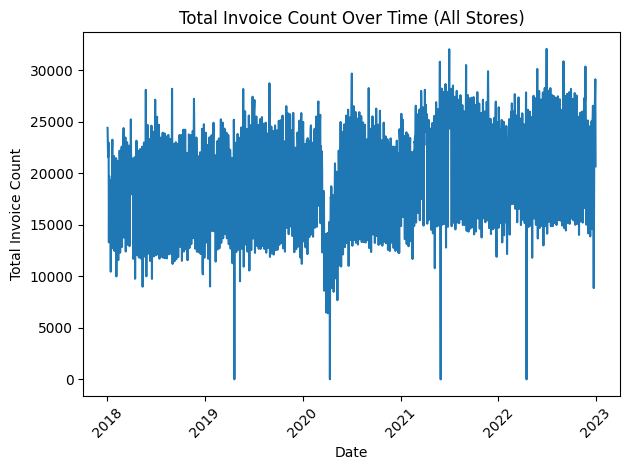

In [4]:
daily_total = df.groupby("invoice_date", as_index=False)["invoice_count"].sum()

plt.figure()
plt.plot(daily_total["invoice_date"], daily_total["invoice_count"])
plt.title("Total Invoice Count Over Time (All Stores)")
plt.xlabel("Date")
plt.ylabel("Total Invoice Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

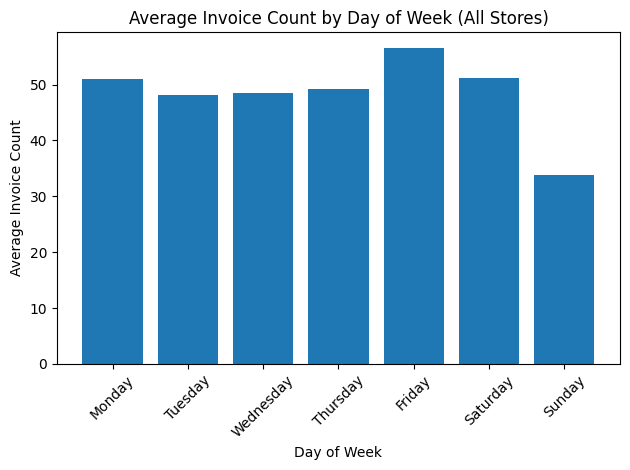

In [5]:
dow_avg = df.groupby("dow_name", as_index=False)["invoice_count"].mean()

order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
dow_avg["dow_name"] = pd.Categorical(dow_avg["dow_name"], categories=order, ordered=True)
dow_avg = dow_avg.sort_values("dow_name")

plt.figure()
plt.bar(dow_avg["dow_name"].astype(str), dow_avg["invoice_count"])
plt.title("Average Invoice Count by Day of Week (All Stores)")
plt.xlabel("Day of Week")
plt.ylabel("Average Invoice Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
print("Overall invoice_count summary:")
print(df["invoice_count"].describe())

print("\nTop 10 stores by average invoice_count:")
print(df.groupby("store_id")["invoice_count"].mean().sort_values(ascending=False).head(10))

print("\nCorrelation (invoice_count vs bay_count) (ignoring missing bay_count):")
tmp = df[["invoice_count", "bay_count"]].dropna()
print(tmp.corr(numeric_only=True))

Overall invoice_count summary:
count    773266.000000
mean         48.564835
std          18.424912
min           0.000000
25%          36.000000
50%          47.000000
75%          59.000000
max         285.000000
Name: invoice_count, dtype: float64

Top 10 stores by average invoice_count:
store_id
611652    110.522079
615287     99.832680
230574     92.887507
231320     89.088416
615212     87.660325
601811     87.265363
594140     86.256009
100510     83.542155
611205     83.316025
614650     82.965922
Name: invoice_count, dtype: float64

Correlation (invoice_count vs bay_count) (ignoring missing bay_count):
               invoice_count  bay_count
invoice_count       1.000000   0.267689
bay_count           0.267689   1.000000
